# Chapter 3: A tour of machine learning classifiers using scikit-learn
___
The second of a series of notebooks following the exercises outlined in Python Machine Learning (Second Edition), by Sebastian Raschka & Vahid Mirjalili.

## Part 1: Revisiting the perceptron with sklearn

This time we'll work with 3 different flower classes and use the built-in perceptron class of scikit learn

In [1]:
from sklearn import datasets
import numpy as np

In [2]:
iris = datasets.load_iris() # a dictionary-like structure
X = iris.data[:, [2, 3]] # 2D np array
y = iris.target # np array
print('Class labels: ', np.unique(y))

Class labels:  [0 1 2]


*Using integer class labels is common practice and recommended due to the smaller memory footprint and reduced likelihood for technical glitches.*
<br><br>
Unlike in Ch. 2, here we will divide our data into a training set and a test set so that we can evaluate how our model performs on unseen test data. Sklearn's ```train_test_split``` method has many useful parameters: 
- **size** defines the fraction of the input data to save as test data 
- **random_state** defines the seed used for shuffling the data prior to splitting it into testing and training sets 
- **stratify** ensures that both the training and test set have the same proportions of class labels as the input data

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
print('Label counts in y: ', np.bincount(y))
print('Label counts in y_train: ', np.bincount(y_train))
print('Label counts in y_test: ', np.bincount(y_test))

Label counts in y:  [50 50 50]
Label counts in y_train:  [35 35 35]
Label counts in y_test:  [15 15 15]


Recall from last chapter that gradient descent can be optimized by **scaling the features** in the training set. Sklearn has built in functions to do this for us. The ```fit``` method of the ```StandardScaler``` class learns mean and standard deviation of the training data and then the ```transform``` method is used to standardize the training data using these scaling parameters. *Note that we should always use the same scaling parameters to scale the training and the test sets.*

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Most sklearn algorithms support multi-class classification using the **One-versus Rest (OVR)** method. So we can feed in all three classes into the sklearn perceptron.

In [6]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=100, eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=100, n_jobs=1, penalty=None, random_state=1, shuffle=True,
      verbose=0, warm_start=False)

Finding the right learning rate usually requires some experimentation. Too big, and we can overshoot the global cost minimum. Too small, and we will require too many steps to converge. For now we'll just start with a learning rate of 0.1 and we'll fine tune it later. Let's evaluate how our trained perceptron performs on the test set.

In [7]:
y_pred = ppn.predict(X_test_std)
n_errors = (y_test != y_pred).sum()
print('Misclassified samples: {} ({:.2f}%)'.format(
    n_errors, 100*n_errors/len(y_pred)))

Misclassified samples: 3 (6.67%)


We can evaluate the performance of our model using various metrics. *Accuracy* is the most common metric reported, and sklearn has several built-in functions to report these measures available in its **metrics** class:

In [8]:
from sklearn.metrics import accuracy_score
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.93


Alternately, each classifier in sklearn has a **```score```** function which combines the ```predict``` and ```accuracy_score``` calls:

In [9]:
print('Accuracy: {:.2f}'.format(ppn.score(X_test_std, y_test)))

Accuracy: 0.93


Now let's visualize the decision boundaries that we learned, highlighting the data points in the test set.

In [10]:
import matplotlib.pyplot as plt
from extra import plot_decision_regions

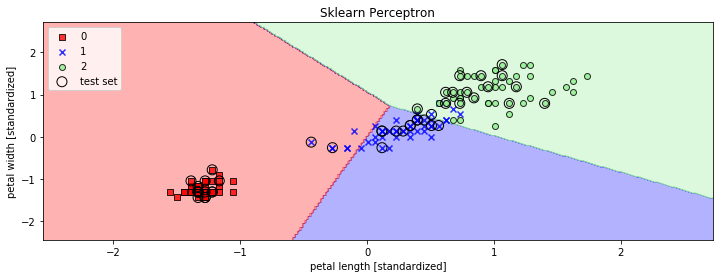

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std)) # vertical stack: rows on top of rows
y_combined = np.hstack((y_train, y_test)) # horizontal stack: columns next to columns
plt.figure(figsize=(12, 4))
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105,150))
plt.title('Sklearn Perceptron')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

As we can see from the plot above, the data were not linearly separable to begin with. Recall that the Perceptron classifier will not converge unless the classes are linearly separable, so maybe this model was not the ideal choice here.

<br>*Maybe* the data might be linearly separable if we perform PCA:

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

Accuracy: 0.89


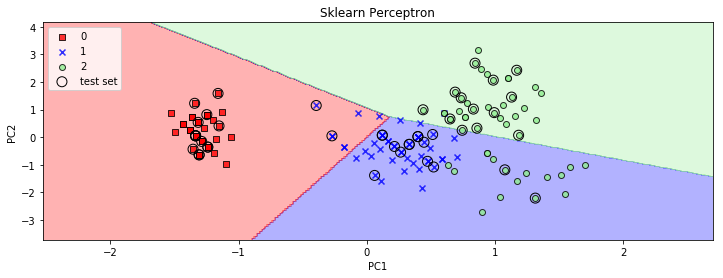

In [13]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.3, random_state=1, stratify=y)

sc = StandardScaler()
sc.fit(X_train_pca)
X_train_pca_std = sc.transform(X_train_pca)
X_test_pca_std = sc.transform(X_test_pca)

ppn2 = Perceptron(n_iter=100, eta0=0.1, random_state=1)
ppn2.fit(X_train_pca_std, y_train_pca)

print('Accuracy: {:.2f}'.format(ppn.score(X_test_pca_std, y_test_pca)))

X_combined_pca_std = np.vstack((X_train_pca_std, X_test_pca_std)) # vertical stack: rows on top of rows
y_combined_pca = np.hstack((y_train_pca, y_test_pca)) # horizontal stack: columns next to columns
plt.figure(figsize=(12, 4))
plot_decision_regions(X=X_combined_pca_std,
                      y=y_combined_pca,
                      classifier=ppn,
                      test_idx=range(105,150))
plt.title('Sklearn Perceptron')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper left')
plt.show()

Hmmm, so we actually do worse. Comparing the scatter plots, you can see why. So PCA isn't necesarily a good way to make the data more clusterable.

___
## Part 2: Logistic regression

Logistic regression is a fundamentally different type of linear model. In Adaline and the Perceptron, our linear function $\textbf{w}^T\textbf{x}$ was in some way (using some threshold) supposed to equal the **class label** of the sample $\textbf{x}$. In logistic regression, $\textbf{w}^T\textbf{x}$ is not a linear model of $\textbf{x}$'s label but a linear model of  the **log-odds ratio** that $\textbf{x}$ is in one class vs. another (*logistic regression is fundamentally a binary classifier though it can be extended to multiclass samples using the One-versus-Rest technique - I hope we cover that later*). Formally, we posit that:

\begin{equation}
log\Big(\frac{p(y=1|\textbf{x})}{1-p(y=1|\textbf{x})}\Big) = \sum_{i=0}^{d} w_ix_i = \textbf{w}^{T}\textbf{x} = z
\end{equation}

(*The sentances that follow in this paragraph are just my own intuitions about the matter*). The reason that we model odds ratio and not the probability directly is because $\textbf{w}^T\textbf{x}$ is not a function bounded between 0 and 1. The reason we use the **log**-odds ratio and not just the odds ratio is probably because it reduces the potential for numerical underflow/overflow when probabilities get very close to 0 or 1. 
<br>

So $\textbf{w}^T\textbf{x}$ is the quantity that we actually work with in our model, but to turn this back into a probability, we use the inverse of the log-odds ratio, called the **sigmoid function**:

\begin{equation}
\phi(z) = \frac{1}{1+e^{-z}}
\end{equation}

,where $z=\textbf{w}^T\textbf{x}$, which we are using to model the log-odds-ratio. In other words:

\begin{equation}
\phi(z) = \frac{1}{1+e^{-\textbf{w}^T\textbf{x}}} = \frac{1}{1+e^{-log\big(\frac{p(y=1|\textbf{x})}{1-p(y=1|\textbf{x})}\big)}} = \frac{1}{1+\frac{1-p(y=1|\textbf{x})}{p(y=1|\textbf{x})} }
\end{equation}

Note that as $p(y=1|\textbf{x}) \rightarrow 1$, then $z \rightarrow \infty$ and $\phi(z) \rightarrow 1$. Conversely, as $p(y=1|\textbf{x}) \rightarrow 0$, then $z \rightarrow -\infty$ and $\phi(z) \rightarrow 0$. See below for a visual.

In [14]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

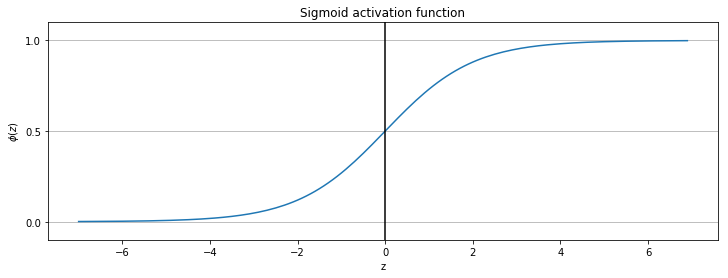

In [15]:
z_ = np.arange(-7,7,0.1)
phi_z = sigmoid(z_)
plt.figure(figsize=(12,4))
plt.plot(z_, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1,1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
plt.title('Sigmoid activation function')

# y axis tics and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.show()

In logistic regression, the sigmoid function $\phi(z) = \phi( \textbf{w}^T \textbf{x} )$ is the *activation function* that we compare against our known labels $y_i$ in order to define our error or loss and determine how to update our weights. Predicted class labels are produced by thresholding $\phi(z)$ at 0.5, but it is also useful to look at $\phi(z)$ directly to get some notion of how *confident* we are in the predicted labels.

In logistic regression, rather than thinking about **minimizing a cost**, we're thinking about **maximizing a likelihood** (the two are not necessarily different it's just conceptually more convenient to think about likelihood maximization here). The likelihood function that we are trying to maximize is a likelihood over the weights:

\begin{equation}
L( \textbf{w} ) = P \big( \textbf{y} \; | \;\textbf{x}, \textbf{w} \big) = \prod_{i=1}^{n} \Big( \phi \Big( z^{(i)} \Big) \Big) ^{y^{(i)}} \Big( 1 - \phi \Big( z^{(i)} \Big) \Big) ^{1-y^{(i)}}
\end{equation}

Maximizing (4) means maximizing $\phi \big( z^{(i)} \big)$ when $y^{(i)} = 1$ and minimizing $\phi \big( z^{(i)} \big)$ when $y^{(i)} = 0$. **Notice in the likelihood equation (4) that we are assuming that all of our samples are independent!**

In practice we actually try to maximize the log likelihood, because it breaks up the product into a sum (making it easier to take the derivative) and because it reduces the potential for numerical under/overflow:

\begin{equation}
l( \textbf{w} ) = logL( \textbf{w} ) =  \sum_{i=1}^{n} \Big[ \; y^{(i)} log \Big( \phi \Big( z^{(i)} \Big) \Big) + \Big( 1-y^{(i)} \Big) log \Big( 1 - \phi \Big( z^{(i)} \Big) \Big) \; \Big]
\end{equation}

So we can use an optimization algorithm like *gradient ascent* to maximize the log-likelihood. Or, in order to make use of our previous Adaline implementation, we can define a cost function as the negative log-likelihood:

\begin{equation}
J \big( \textbf{w} \big) =  \sum_{i=1}^{n} \Big[ \; -y^{(i)} log \Big( \phi \Big( z^{(i)} \Big) \Big) - \Big( 1-y^{(i)} \Big) log \Big( 1 - \phi \Big( z^{(i)} \Big) \Big) \; \Big]
\end{equation}

___
### The gradient descent learning algorithm for logistic regression

Now we have to figure out how to update our weights $\textbf{w}$ in order to maximize our likelihood. Let's start by taking the partial derivative of the log likelihood (4) with respect to one weight $w_j$:

\begin{equation}
\frac{\delta}{\delta w_j} l(\textbf{w}) = 
\sum_{i=1}^{n} \Big( \frac{y^{(i)}}{\phi(z^{(i)})} - \frac{1-y^{(i)}}{1-\phi(z^{(i)})} \Big) \frac{\delta}{\delta w_j} \phi(z^{(i)}) 
\end{equation}

Then, evaluating $\frac{\delta}{\delta w_j} \phi(z)$, we get:


$$
\frac{\delta}{\delta w_j} \phi(z^{(i)}) = 
\frac{\delta}{\delta z^{(i)}} \phi(z^{(i)}) \frac{\delta z^{(i)}}{\delta w_j} = 
\frac{\delta}{\delta z^{(i)}} \Big[ \frac{1}{1 + e^{-z^{(i)}}} \Big] \frac{\delta z^{(i)}}{\delta w_j} = 
\Big[ \frac{e^{-z^{(i)}}}{( 1 + e^{-z^{(i)}})^2} \Big] \frac{\delta z^{(i)}}{\delta w_j} =
$$

\begin{equation}
\Big[ \frac{1}{1 + e^{-z^{(i)}}} \Big( 1 -  \frac{1}{1 + e^{-z^{(i)}}} \Big) \Big] \frac{\delta z^{(i)}}{\delta w_j} = 
\phi(z^{(i)}) (1-\phi(z^{(i)})) \frac{\delta z^{(i)}}{\delta w_j} = 
\phi(z^{(i)}) (1-\phi(z^{(i)})) \; x^{(i)}_j 
\end{equation}

Putting it all together:

$$
\frac{\delta}{\delta w_j} l(\textbf{w}) = 
\sum_{i=1}^{n} \Big( \frac{y^{(i)}}{\phi(z^{(i)})} - 
\frac{1-y^{(i)}}{1-\phi(z^{(i)})} \Big) \phi(z^{(i)}) (1-\phi(z^{(i)})) \; x^{(i)}_j =
$$

\begin{equation}
\sum_{i=1}^{n} \Big( y^{(i)} (1-\phi(z^{(i)})) - (1-y^{(i)})\phi(z^{(i)} \Big) \; x^{(i)}_j =
\sum_{i=1}^{n} \big( y^{(i)} - \phi(z^{(i)}) \big) \; x^{(i)}_j
\end{equation}


So, in each iteration, we update our weights so as to follow this gradient of the likelihood function and increase the overall likelihood:

\begin{equation}
w_j := w_j + \Delta w_j = 
w_j + \eta  \frac{\delta}{\delta w_j} l(\textbf{w}) =
w_j + \eta  \sum_{i=1}^{n} \big( y^{(i)} - \phi(z^{(i)}) \big) \; x^{(i)}_j
\end{equation}

**Miraculously**, our gradient ascent rule for learning logistic regression weights is the **same** as the gradient descent rule for learning weights in the Ch. 2 **Adaline** procedure. Since we update all the weights simultaneously, we can write the general update rule as:

\begin{equation}
\textbf{w} := \textbf{w} + \Delta \textbf{w} = 
\textbf{w} + \eta \nabla l(\textbf{w}) = 
\textbf{w} - \eta \nabla J(\textbf{w})
\end{equation}

___
### Adapting our adaline procedure to do logistic regression

We'll make slight tweaks to our AdalineGD implementation in ```models.py``` in order to adapt it for logistic regression. Namely, we want to change the cost function that reports the error in each epoch to equation (6), change the activation function from linear to sigmoid, and change the threshold function to return class labels 0 and 1 instead of -1 and 1.
<br><br>
Our initial implementation will only work for binary classification (2 classes):

In [16]:
from models import LogisticRegressionGD

In [17]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.05,
                            n_iter=1000,
                            random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

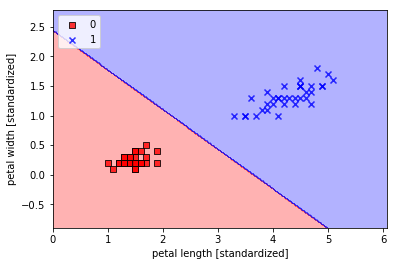

In [18]:
plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset, 
                      classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

let's compare this against the perceptron

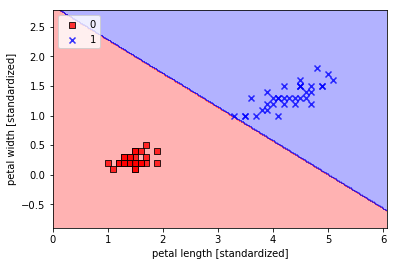

In [19]:
ppn2 = Perceptron(n_iter=500, eta0=0.1, random_state=1)
ppn2.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset, 
                      classifier=ppn2)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

___
# Logistic regression with scikit-learn

This time we'll work with 3 flower classes and train an sklearn logistic regression model.

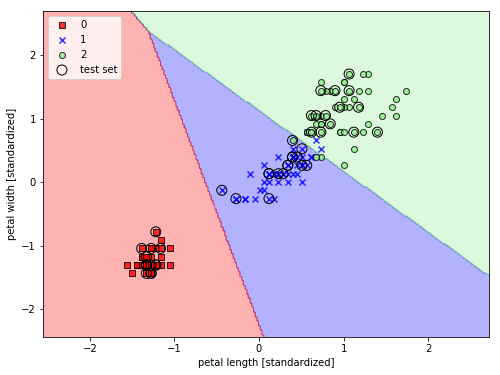

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
# C is the inverse of regularization strength; must be a positive float.
# Like in support vector machines, smaller values specify stronger regularization.

lr.fit(X_train_std, y_train)
plt.figure(figsize=(8,6))
plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=lr,
                      test_idx=range(105,150)
                     )
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

Now that the model is trained we can use it to predict class membership probabilities using the ``predict_proba`` and numpy's ``argmax`` method. For example, below we predict the class probabilities of the first three test samples. The first flower is predicted to be in class 2, wheras the second and third flowers are predicted to be in class 0.

In [21]:
lr.predict_proba(X_test_std[:3,:])

array([[  3.20136878e-08,   1.46953648e-01,   8.53046320e-01],
       [  8.34428069e-01,   1.65571931e-01,   4.57896429e-12],
       [  8.49182775e-01,   1.50817225e-01,   4.65678779e-13]])

In [22]:
lr.predict_proba(X_test_std[:3,:]).argmax(axis=1)

array([2, 0, 0])

If all we are interested in are class labels, then we can use the model's ``predict`` method directly:

In [23]:
lr.predict(X_test_std[:3,:])

array([2, 0, 0])

One strange feature of sci-kit learn is that it expects input data as two dimensional arrays. So if we want to predict the class of a single sample, we have to reshape it:

In [24]:
lr.predict(X_test_std[0,:].reshape(1,-1))

array([2])

___
# Addressing overfitting with regularization

There is often a tradeoff between bias and variance in machine learning models. Very complex models can over-fit the training data and have low bias, but if we train the model many times on different bootstrapped samples from the training data, we might get high variability in our predictions for a particular test sample. On the other hand, over-simplified models will have low variance when trained on different training subsets, but will have high error in their predictions, meaning high bias.
<br><br>
One way to find a good bias-variance tradeoff is through regularization. Regularization is useful for dealing with collinearity (high correlation among features), filter out noise, and eventually prevent overfitting. In order for regularization to work properly, our features must be approximately the same **scale**, which is another reason why feature scaling is important.
<br><br>
The concept behind regularization is to introduce a bias to penalize extreme parameter (weight) values. The most common form of regularization is called L-2 regularization:

\begin{equation}
\frac{\lambda}{2} \lVert \textbf{w} \rVert ^{2} = \frac{\lambda}{2} \sum^{m}_{j=1} w_{j}^{2}
\end{equation}

Here, $\lambda$ is called the **regularization parameter**. The cost function of logistic regression can be regularized by adding a simple regularization term, which will shrink the weights during training:

\begin{equation}
J \big( \textbf{w} \big) =  \sum_{i=1}^{n} \Big[ \; -y^{(i)} log \Big( \phi \Big( z^{(i)} \Big) \Big) - \Big( 1-y^{(i)} \Big) log \Big( 1 - \phi \Big( z^{(i)} \Big) \Big) \; \Big] + \frac{\lambda}{2} \lVert \textbf{w} \rVert ^{2}
\end{equation}

Via the regularization parameter we can control how well we fit the training data while keeping the weights small. Be increasing $\lambda$ we increase the regularization strength.
<br><br>
In scikit-learn, the regularization parameter ``C`` in the ``LogisticRegression`` class is actually the inverse of $\lambda$. This is a convention taken from SVMs. So decreasing ``C`` increases the regularization strength, a difference which we can visualize by plotting the L2-regularization path for the two weight coefficients:

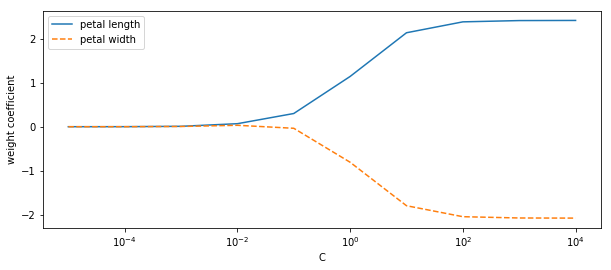

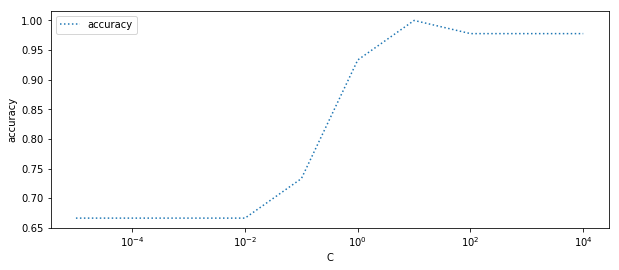

In [38]:
weights, acc, params = [], [], []
for c in np.arange(-5,5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    acc.append(lr.score(X_test_std, y_test))
    params.append(10.**c)
    
weights = np.array(weights)
acc = np.array(acc)
plt.figure(figsize=(10,4))
plt.plot(params, weights[:,0],
         label='petal length')
plt.plot(params, weights[:,1], linestyle='--',
         label='petal width')

plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(params, acc, linestyle=':',
         label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

The preceeding code trained ten linear regression classifiers with different regularization parameters (x-axis). Smaller values of ``C`` mean stronger regularization. Plotted on the Y-axis are the weight parameters associated with the two petal features of flower class 1. As you can see, decreasing C shrinks the weights down to zero.
<br><br>
In the second plot we can see how the test accuracy depends on the regularization parameter. Clearly too-strong regularization (low C values) is not good for accuracy, which makes sense b/c both weights/coefficients are close to zero. But a little bit of regularization is good, as evidenced by the tiny accuracy peak around C=10.

___
# Maximum margin classification with SVMs

For the time being we're going to skip this section so that we can proceed to decision trees / random forests.

___
# Decision tree learning

We already explored decision trees / random forests in detail in a separate notebook (``~/git/LINCS_target_prediction/random_forest.ipynb``), so here we'll just touch mainly on the details we didn't cover before.
<br>
### Information gain
As we know, you grow a decision tree by splitting the data at each node using the feature that **maximizes the information gain**. Formally, the information gain, $IG$, of splitting the data at parent node $D_p$ using feature $f$ is defined in terms of the impurity $I$ of the parent and the child nodes $D_j$:

$$
IG( \ D_p \ , \ f \ ) = I( \ D_p \ ) - \sum^{m}_{j=1} \ \frac{N_j}{N_p} I( \ D_j \ )
$$

Note that in practice most libraries grow **binary** trees, meaning that each parent gives rise to only two children ($m=2$). There are several measures of the impurity $I$ of node $t$ that are commonly used, all defined in terms of class probabilities $p( \ i \ | \ t \ )$:
<br><br>
- **Entropy:** 
$$ I_H = - \sum^{c}_{i=1} p( \ i \ | \ t \ ) \ log_2 \ p( \ i \ | \ t \ )$$
<br><br>
- **Gini Impurity:**    
$$ I_G = \sum^{c}_{i=1} p( \ i \ | \ t \ ) \big( 1 - p( \ i \ | \ t \ ) \big)$$
<br><br>
- **Classification Error:**
$$ I_E = 1 \ - \ max \{ p( \ i \ | \ t \ ) \}$$

<br>
All these measures of impurity are maximal when the probability distribution over the data classes at the node is uniform, and are 0 when the distribution is a point distribution (when one class is 100% certain). The plot below compares the impurity measures for different class probabilities in binary classification.

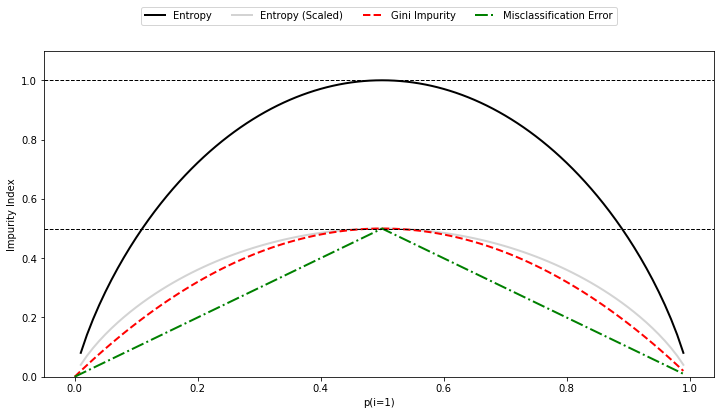

In [50]:
def gini(p): return 2*(p)*(1-p)
def entropy(p): return -p*np.log2(p) - (1-p)*np.log2(1-p)
def error(p): return 1 - np.max([p, 1-p])

x_ = np.arange(0.0, 1.0, 0.01)
ent_ = [entropy(p) if p != 0 else None for p in x_]
sc_ent_ = [e/2 if e != None else None for e in ent_]
err_ = [error(i) for i in x_]
gini_ = gini(x_)

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent_, sc_ent_, gini_, err_,],
                          ['Entropy', 'Entropy (Scaled)', 'Gini Impurity', 'Misclassification Error',],
                          ['-','-','--','-.',],
                          ['black', 'lightgrey', 'red', 'green', 'cyan',]
                         ):
    line = ax.plot(x_, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.15),
          ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

In [ ]:
PRUNING